In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd
from omni import *

In [3]:
"""
Creates a MobileNetV3 Model as defined in:
Andrew Howard, Mark Sandler, Grace Chu, Liang-Chieh Chen, Bo Chen, Mingxing Tan, Weijun Wang, Yukun Zhu, Ruoming Pang, Vijay Vasudevan, Quoc V. Le, Hartwig Adam. (2019).
Searching for MobileNetV3
arXiv preprint arXiv:1905.02244.
"""

import torch.nn as nn
import math


__all__ = ['mobilenetv3_large', 'mobilenetv3_small']


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, _make_divisible(channel // reduction, 8)),
                nn.ReLU(inplace=True),
                nn.Linear(_make_divisible(channel // reduction, 8), channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size = 3, stride = stride,
                            padding = 1, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size = 1, stride = 1,
                            padding = 0, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size, stride, use_se, use_hs):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        self.identity = stride == 1 and inp == oup

        if inp == hidden_dim:
            self.conv = nn.Sequential(
                # dw
                ODConvBN(hidden_dim, hidden_dim, kernel_size, stride, groups=hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                # pw-linear
                ODConv2d(hidden_dim, oup, 1, 1),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                ODConvBN(inp, hidden_dim, kernel_size = 1, stride = 1),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # dw
                ODConvBN(hidden_dim, hidden_dim, kernel_size, stride, groups=hidden_dim),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # pw-linear
                ODConv2d(hidden_dim, oup, 1, 1),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV3(nn.Module):
    def __init__(self, cfgs, mode, num_classes=1000, width_mult=1.):
        super(MobileNetV3, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = cfgs
        assert mode in ['large', 'small']

        # building first layer
        input_channel = _make_divisible(16 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = InvertedResidual
        for k, t, c, use_se, use_hs, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            exp_size = _make_divisible(input_channel * t, 8)
            layers.append(block(input_channel, exp_size, output_channel, k, s, use_se, use_hs))
            input_channel = output_channel
        self.features = nn.Sequential(*layers)

        # building last several layers
        self.conv = conv_1x1_bn(input_channel, exp_size)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        output_channel = {'large': 1280, 'small': 1024}

        output_channel = _make_divisible(output_channel[mode] * width_mult, 8) if width_mult > 1.0 else output_channel[mode]
        self.classifier = nn.Sequential(
            nn.Linear(exp_size, output_channel),
            h_swish(),
            nn.Dropout(0.2),
            nn.Linear(output_channel, num_classes),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def mobilenetv3_large(**kwargs):
    """
    Constructs a MobileNetV3-Large model
    """
    cfgs = [
        # k, t,   c,  SE, HS, s
        [3,   1,  16, 0, 0, 1],
        [3,   4,  24, 0, 0, 2],
        [3,   3,  24, 0, 0, 1],
        [5,   3,  40, 1, 0, 2],
        [5,   3,  40, 1, 0, 1],
        [5,   3,  40, 1, 0, 1],
        [3,   6,  80, 0, 1, 2],
        [3, 2.5,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [5,   6, 160, 1, 1, 2],
        [5,   6, 160, 1, 1, 1],
        [5,   6, 160, 1, 1, 1]
    ]
    return MobileNetV3(cfgs, mode='large', **kwargs)


def mobilenetv3_small(**kwargs):
    """
    Constructs a MobileNetV3-Small model
    """
    cfgs = [
        # k,   t,  c, SE, HS, s
        [3,    1,  16, 1, 0, 2],
        [3,  4.5,  24, 0, 0, 2],
        [3, 3.67,  24, 0, 0, 1],
        [5,    4,  40, 1, 1, 2],
        [5,    6,  40, 1, 1, 1],
        [5,    6,  40, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    6,  96, 1, 1, 2],
        [5,    6,  96, 1, 1, 1],
        [5,    6,  96, 1, 1, 1],
    ]

    return MobileNetV3(cfgs, mode='small', **kwargs)


In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Training

In [5]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np

In [6]:
def load_data(data_dir, download = True):

  transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  train_data = datasets.CIFAR10(
      root = data_dir, train = True,
      download = download, transform = transform
  )

  test_data = datasets.CIFAR10(
      root = data_dir, train = False,
      download = download, transform = transform
  )

  return (train_data, test_data)

train_data, test_data = load_data('./data/cifar10')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
batch_size = 256
num_workers = 4

train_loader = DataLoader(train_data, batch_size = batch_size,
                          shuffle = True, num_workers = num_workers)
test_loader = DataLoader(test_data, batch_size = batch_size,
                         shuffle = True, num_workers = num_workers)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
def mixup_data(x, y, device, alpha = 1.0):
  if alpha > 0:
    lam = np.random.beta(alpha, alpha)
  else:
    lam = 1

  batch_size = x.shape[0]
  index_sample = torch.randperm(batch_size).to(device)

  mixed_x = lam * x + (1 - lam) * x[index_sample, :]
  y, y_sampled =  y, y[index_sample]

  return mixed_x, y, y_sampled, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
  return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [10]:
import logging
import os
from tqdm.notebook import tqdm

def check_logging_directory(path):
  parent_directory = os.path.dirname(path)
  if not os.path.exists(parent_directory):
    os.makedirs(parent_directory)
    print("Create new directory")

logging_path = './logging/mixup_mobilenetv3_omni.log'
check_logging_directory(logging_path)

logging.basicConfig(filename=logging_path, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [11]:
import torch.optim as optim

num_epochs = 100
learning_rate = 0.001

mb_v3 =  mobilenetv3_small(num_classes = 10).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(mb_v3.parameters(), lr=learning_rate,weight_decay=1e-5)


count_parameters(mb_v3)

2396571

In [12]:
# Huấn luyện mô hình
train_loss, val_loss = [], []
train_acc, val_acc = [], []

epoch_bar = tqdm(desc = 'Epoch',
                 total = num_epochs, position = 1)
train_bar = tqdm(desc = 'Training', total = len(train_loader),
                 position = 1, leave = True)
val_bar = tqdm(desc = 'Validation', total = len(test_loader),
               position = 1, leave = True)

print("🚀 Training MobileNetV3 - Omni Dimensional Dynamic Convolution 🚀")
logging.info("🚀 Training MobileNetV3 - Omni Dimensional Dynamic Convolution 🚀")

for epoch in range(num_epochs):

    epoch_bar.set_description(f'Epoch {epoch + 1}/{num_epochs}')

    mb_v3.train()
    running_loss = 0.0
    running_acc = 0.0
    total_loss = 0.0
    total_acc = 0.0

    total = 0
    for i, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)

        X, y_origin, y_sampled, lam = mixup_data(X, y, device, alpha = 0.4)

        # Forward pass
        output = mb_v3(X)
        # loss = criterion(output, y)
        loss = mixup_criterion(criterion, output, y_origin, y_sampled, lam)
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (i + 1)
        total_loss += loss_t

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculating the accuracy
        _, predicted = torch.max(output.data, 1)
        n_correct = (lam * predicted.eq(y_origin.data).cpu().sum().float()
                    + (1 - lam) * predicted.eq(y_sampled.data).cpu().sum().float())

        acc_t = n_correct / len(predicted) * 100
        running_acc += (acc_t - running_acc) / (i + 1)

        total_acc += n_correct
        total += y.shape[0]


        train_bar.set_postfix(loss = running_loss,
                              acc = f"{running_acc:.2f}%",
                              epoch = epoch + 1)
        train_bar.update()

    current_loss = total_loss / len(train_loader)
    current_acc = total_acc / total * 100
    train_loss.append(current_loss)
    train_acc.append(current_acc)

    print("========================================")
    print("\033[1;34m" + f"Epoch {epoch + 1}/{num_epochs}" + "\033[0m")
    print(f"Train Loss: {current_loss:.2f}\t|\tTrain Acc: {current_acc:.2f}%")

    logging.info("========================================")
    logging.info("\033[1;34m" + f"Epoch {epoch + 1}/{num_epochs}" + "\033[0m")
    logging.info(f"Train Loss: {current_loss:.2f}  -   Train Acc: {current_acc:.2f}%")


    # Eval trên valid set
    running_loss = 0.0
    running_acc = 0.0
    total_loss = 0.0
    total_acc = 0.0

    total = 0
    mb_v3.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(test_loader):

            X, y = X.to(device), y.to(device)
            # Forward pass
            output = mb_v3(X)

            # Calculate Loss
            loss = criterion(output, y)
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (i + 1)
            total_loss += loss_t

            # Calculate Accuracies
            _, predicted = torch.max(output.data, 1)
            n_correct = (predicted == y).sum().item()
            acc_t = n_correct / len(predicted) * 100
            running_acc += (acc_t - running_acc) / (i + 1)
            total_acc += n_correct

            total += y.shape[0]

            val_bar.set_postfix(loss = running_loss,
                                acc = f"{running_acc:.2f}%",
                                epoch = epoch + 1)
            val_bar.update()

    current_loss = total_loss / len(test_loader)
    current_acc = total_acc / total * 100

    val_loss.append(current_loss)
    val_acc.append(current_acc)

    print(f"Val Loss: {current_loss:.2f}\t|\tVal Acc: {current_acc:.2f}%")
    logging.info(f"Val Loss: {current_loss:.2f}  -  Val Acc: {current_acc:.2f}%")

    train_bar.n = 0
    val_bar.n = 0
    epoch_bar.update()

print("========================================")
print("Training Completed! 😀")
logging.info("========================================")
logging.info("Training Completed! 😀")

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

🚀 Training MobileNetV3 - Omni Dimensional Dynamic Convolution 🚀
Epoch 1/100
Train Loss: 1.73	|	Train Acc: 38.30%
Val Loss: 1.44	|	Val Acc: 49.73%
Epoch 2/100
Train Loss: 1.37	|	Train Acc: 55.28%
Val Loss: 0.97	|	Val Acc: 66.96%
Epoch 3/100
Train Loss: 1.23	|	Train Acc: 61.80%
Val Loss: 0.84	|	Val Acc: 71.61%
Epoch 4/100
Train Loss: 1.13	|	Train Acc: 65.92%
Val Loss: 0.73	|	Val Acc: 77.24%
Epoch 5/100
Train Loss: 1.06	|	Train Acc: 68.66%
Val Loss: 0.68	|	Val Acc: 78.11%
Epoch 6/100
Train Loss: 1.01	|	Train Acc: 70.57%
Val Loss: 0.65	|	Val Acc: 80.26%
Epoch 7/100
Train Loss: 0.96	|	Train Acc: 72.66%
Val Loss: 0.60	|	Val Acc: 81.77%
Epoch 8/100
Train Loss: 0.96	|	Train Acc: 72.51%
Val Loss: 0.64	|	Val Acc: 80.23%
Epoch 9/100
Train Loss: 0.97	|	Train Acc: 72.29%
Val Loss: 0.65	|	Val Acc: 81.39%
Epoch 10/100
Train Loss: 0.91	|	Train Acc: 73.92%
Val Loss: 0.57	|	Val Acc: 82.98%
Epoch 11/100
Train Loss: 0.91	|	Train Acc: 74.38%
Val Loss: 0.62	|	Val Acc: 82.72%
Epoch 12/100
Train Loss: 0.86	|	

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 23/100
Train Loss: 0.75	|	Train Acc: 79.70%
Val Loss: 0.57	|	Val Acc: 85.57%
Epoch 24/100
Train Loss: 0.76	|	Train Acc: 79.33%
Val Loss: 0.50	|	Val Acc: 85.65%
Epoch 25/100
Train Loss: 0.70	|	Train Acc: 81.42%
Val Loss: 0.52	|	Val Acc: 85.22%
Epoch 26/100
Train Loss: 0.69	|	Train Acc: 81.44%
Val Loss: 0.47	|	Val Acc: 86.58%
Epoch 27/100
Train Loss: 0.72	|	Train Acc: 81.21%
Val Loss: 0.51	|	Val Acc: 85.88%
Epoch 28/100
Train Loss: 0.74	|	Train Acc: 79.54%
Val Loss: 0.49	|	Val Acc: 86.48%
Epoch 29/100
Train Loss: 0.66	|	Train Acc: 82.61%
Val Loss: 0.48	|	Val Acc: 86.27%
Epoch 30/100
Train Loss: 0.73	|	Train Acc: 80.00%
Val Loss: 0.50	|	Val Acc: 85.83%
Epoch 31/100
Train Loss: 0.71	|	Train Acc: 80.79%
Val Loss: 0.46	|	Val Acc: 87.12%
Epoch 32/100
Train Loss: 0.71	|	Train Acc: 81.01%
Val Loss: 0.50	|	Val Acc: 86.25%
Epoch 33/100
Train Loss: 0.77	|	Train Acc: 78.50%
Val Loss: 0.51	|	Val Acc: 85.78%
Epoch 35/100
Train Loss: 0.71	|	Train Acc: 80.88%
Val Loss: 0.47	|	Val Acc: 86.96%
Epoc

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 55/100
Train Loss: 0.69	|	Train Acc: 81.03%
Val Loss: 0.45	|	Val Acc: 87.65%
Epoch 56/100
Train Loss: 0.67	|	Train Acc: 82.16%
Val Loss: 0.47	|	Val Acc: 87.53%
Epoch 57/100
Train Loss: 0.70	|	Train Acc: 80.73%
Val Loss: 0.46	|	Val Acc: 87.44%
Epoch 58/100
Train Loss: 0.62	|	Train Acc: 83.58%
Val Loss: 0.51	|	Val Acc: 86.95%
Epoch 59/100
Train Loss: 0.60	|	Train Acc: 84.23%
Val Loss: 0.49	|	Val Acc: 86.85%
Epoch 60/100
Train Loss: 0.68	|	Train Acc: 81.75%
Val Loss: 0.47	|	Val Acc: 87.10%
Epoch 61/100
Train Loss: 0.66	|	Train Acc: 82.20%
Val Loss: 0.47	|	Val Acc: 87.64%
Epoch 62/100
Train Loss: 0.65	|	Train Acc: 82.77%
Val Loss: 0.45	|	Val Acc: 87.77%
Epoch 63/100
Train Loss: 0.64	|	Train Acc: 83.08%
Val Loss: 0.46	|	Val Acc: 87.28%
Epoch 64/100
Train Loss: 0.67	|	Train Acc: 81.30%
Val Loss: 0.49	|	Val Acc: 87.21%
Epoch 65/100
Train Loss: 0.65	|	Train Acc: 82.13%
Val Loss: 0.51	|	Val Acc: 87.19%
Epoch 66/100
Train Loss: 0.72	|	Train Acc: 79.98%
Val Loss: 0.46	|	Val Acc: 88.13%
Epoc

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 90/100
Train Loss: 0.73	|	Train Acc: 79.10%
Val Loss: 0.46	|	Val Acc: 88.31%
Epoch 91/100
Train Loss: 0.60	|	Train Acc: 84.32%
Val Loss: 0.47	|	Val Acc: 88.12%
Epoch 92/100
Train Loss: 0.66	|	Train Acc: 81.89%
Val Loss: 0.48	|	Val Acc: 87.74%
Epoch 93/100
Train Loss: 0.60	|	Train Acc: 83.91%
Val Loss: 0.47	|	Val Acc: 88.24%
Epoch 94/100
Train Loss: 0.69	|	Train Acc: 81.10%
Val Loss: 0.47	|	Val Acc: 87.59%
Epoch 95/100
Train Loss: 0.63	|	Train Acc: 82.36%
Val Loss: 0.47	|	Val Acc: 88.29%
Epoch 98/100
Train Loss: 0.63	|	Train Acc: 82.69%
Val Loss: 0.43	|	Val Acc: 88.31%
Epoch 99/100
Train Loss: 0.65	|	Train Acc: 82.75%
Val Loss: 0.48	|	Val Acc: 88.18%
Epoch 100/100
Train Loss: 0.62	|	Train Acc: 83.06%
Val Loss: 0.44	|	Val Acc: 88.05%
Training Completed! 😀


In [17]:
len(val_loss)

0

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

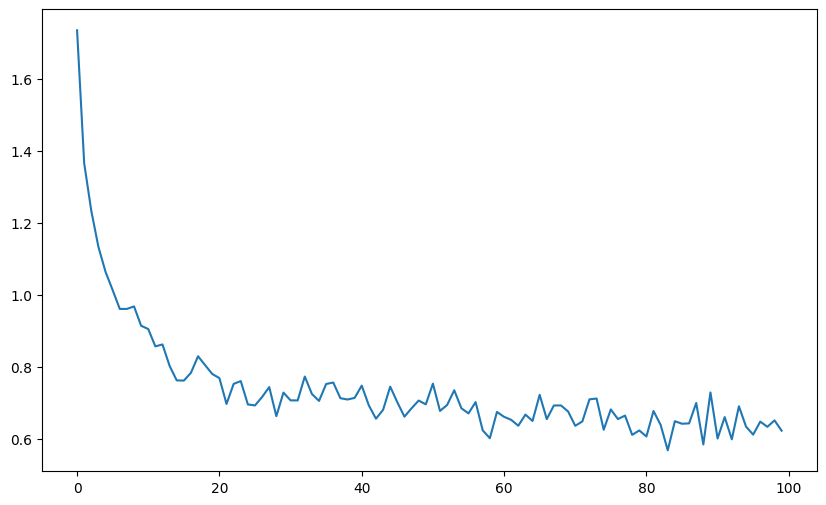

In [16]:
!sudo pip install matplotlib
import matplotlib.pyplot as plt

if not os.path.exists("/plot"):
    os.makedirs("/plot")
    print("Creating a new directory")

def plot_loss(train_loss, val_loss, loss_fig):
    plt.figure(figsize = (10, 6))
    plt.plot(range(num_epochs), train_loss)
    plt.plot(range(num_epochs), val_loss)

    plt.xlabel("Num Epochs")
    plt.ylabel("Loss Value")
    
    plt.savefig(train_fig)
    plt.show()

def plot_accuracy(train_acc, val_acc, acc_fig):
    plt.figure(figsize = (10, 6))
    plt.plot(range(num_epochs), train_acc)
    plt.plot(range(num_epochs), val_acc)

    plt.xlabel("Num Epochs")
    plt.ylabel("Accuracy (%)")
    
    plt.savefig(acc_fig)
    plt.show()

loss_path = "/plot/loss_fig.png"
acc_path = "/plot/acc_fig.png"

plot_loss(train_loss, val_loss, loss_path)
plt_accuracy(train_acc, val_acc, acc_path)
